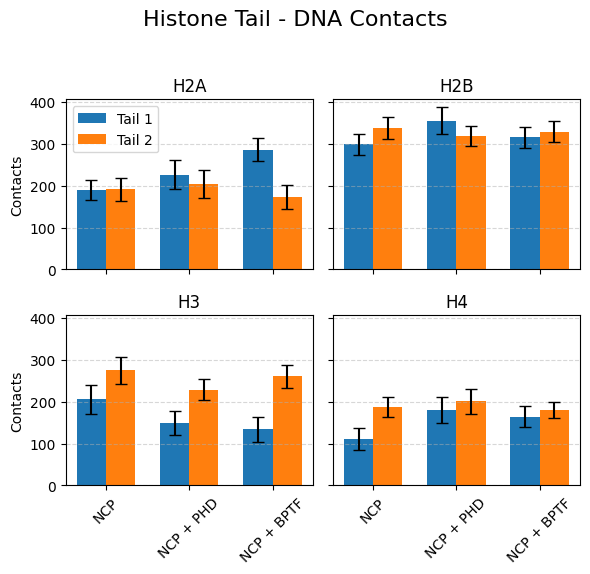

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from math import sqrt

# Set your data directory path
data_dir = "./"  # <<<--- UPDATE IF NEEDED

# Custom x-axis labels
systems = ["nucleosome", "phd_ncp", "bptf_ncp"]
x_labels = {
    "nucleosome": "NCP",
    "phd_ncp": "NCP + PHD",
    "bptf_ncp": "NCP + BPTF"
}

# Histone types to analyze
histones = ["H2a", "H2b", "H3", "H4"]
histone_labels = ["H2A", "H2B", "H3", "H4"]
# Initialize a dictionary to store all results
all_results = {}

for histone in histones:
    histone_results = {}
    for group in systems:
        patterns = [
            f"{group}{histone}tail*1_*.dat",
            f"{group}{histone}tail*2_*.dat"
        ]
        group_results = []
        for pattern in patterns:
            filepaths = sorted(glob(os.path.join(data_dir, pattern)))
            if not filepaths:
                print(f"Warning: No files found for pattern {pattern}")
                group_results.append((np.nan, np.nan))
                continue
            contact_counts = []
            for file in filepaths:
                try:
                    df = pd.read_csv(file, delim_whitespace=True, comment="#", header=None)
                    if len(df.columns) >= 2:
                        contact_counts.append(df[1].values)
                except Exception as e:
                    print(f"Error reading {file}: {e}")
            if contact_counts:
                arr = np.array(contact_counts)
                group_results.append((np.mean(arr), np.std(arr)/sqrt(5)))
            else:
                group_results.append((np.nan, np.nan))
        histone_results[group] = group_results
    all_results[histone] = histone_results

# === Plotting ===
fig, axes = plt.subplots(2, 2, figsize=(6, 6), sharey=True)
axes = axes.flatten()
width = 0.35
x = np.arange(len(systems))

for i, histone in enumerate(histones):
    ax = axes[i]
    results = all_results[histone]

    tail1_means = [results[g][0][0] for g in systems]
    tail2_means = [results[g][1][0] for g in systems]
    tail1_stds = [results[g][0][1] for g in systems]
    tail2_stds = [results[g][1][1] for g in systems]

    x1 = x - width / 2
    x2 = x + width / 2

    bar1 = ax.bar(x1, tail1_means, width, yerr=tail1_stds, label='Tail 1', capsize=4)
    bar2 = ax.bar(x2, tail2_means, width, yerr=tail2_stds, label='Tail 2', capsize=4)

    ax.set_title(f"{histone_labels[i]}")
    ax.set_xticks(x)
    if i in [2, 3]:
        ax.set_xticklabels([x_labels[g] for g in systems], rotation=45, ha='center')
    else:
        ax.set_xticklabels([])

    ax.grid(axis='y', linestyle='--', alpha=0.5)
    if i == 0:
        ax.legend()
    if i % 2 == 0:
        ax.set_ylabel("Contacts")

plt.suptitle("Histone Tail - DNA Contacts", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('tail_dna_contacts.pdf')

